In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1" # "1", "2", "3"

# IPL-VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

In [3]:
import jax
import jmll
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

In [4]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [5]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [6]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## Hard EM

In [7]:
key = jax.random.PRNGKey(314)
key_train, key_samples = jax.random.split(key)

In [8]:
%%time

dim_latent = 50
decoder = jmll.models.HomkDecoder(dim_obs, dim_latent)
n_epochs = 2000
n_its = 4
learning_rate = 1e-3
tx = optax.adam(learning_rate)


lossfn = jmll.hard_decoder.loss_hard_nmll
res = jmll.hard_decoder.train_epoch_full(key_train, X_train, decoder, tx,
                                         dim_latent, lossfn, n_its, n_epochs)
nll_hist, params_decoder, z_decoder = res

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 8.96 s, sys: 903 ms, total: 9.86 s
Wall time: 7.91 s


Text(0.5, 1.0, 'Log-joint')

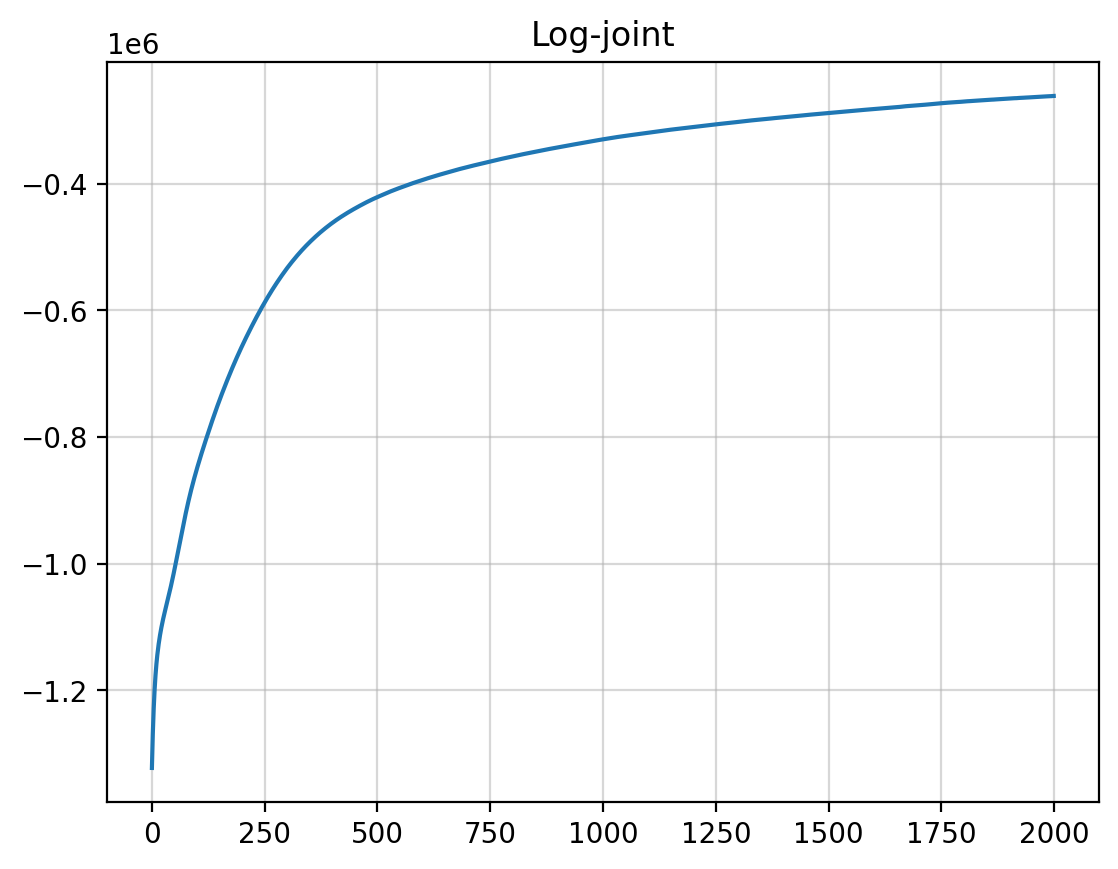

In [9]:
plt.plot(-jnp.array(nll_hist))
plt.grid(alpha=0.5)
plt.title("Log-joint")

## Loss as a function of inner iterations

In [10]:
%%time
learning_rate = 1e-3
tx = optax.adam(learning_rate)
list_n_its = [1, 2, 3, 5, 10, 20, 50]

dict_mll = {}

for n_its in list_n_its:
    res = jmll.hard_decoder.train_epoch_full(key_train, X_train, decoder, tx,
                                             dim_latent, lossfn, n_its, n_epochs)
    nll_hist, params_decoder, z_decoder = res
    dict_mll[n_its] = nll_hist

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 1min 43s, sys: 18.7 s, total: 2min 2s
Wall time: 1min 43s


In [11]:
%store -r hist_mll_vae

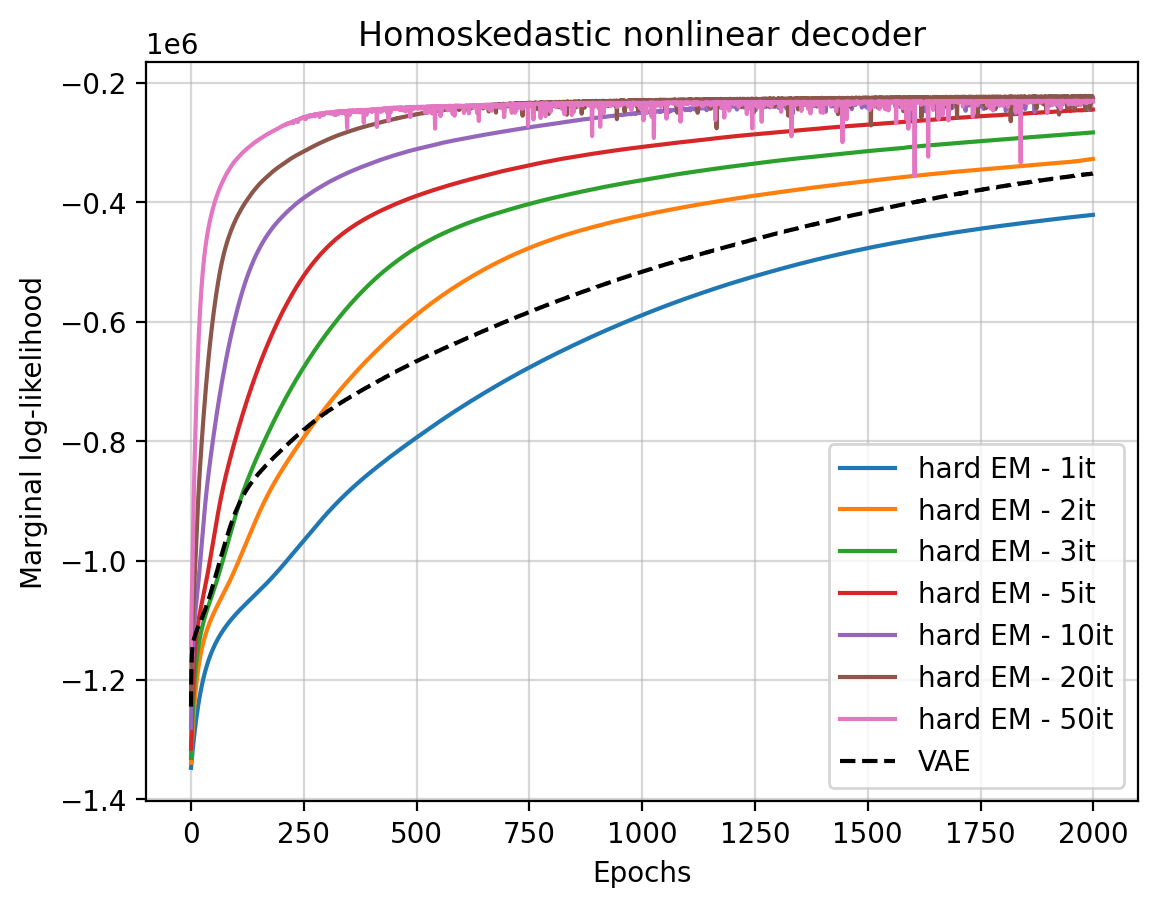

In [12]:
for n_it, nll_hist in dict_mll.items():
    ll_hist = -jnp.array(nll_hist)
    
    plt.plot(ll_hist, label=f"hard EM - {n_it}it")
plt.plot(hist_mll_vae, label="VAE", c="black", linestyle="--")
plt.title("Homoskedastic nonlinear decoder")
plt.ylabel("Marginal log-likelihood")
plt.xlabel("Epochs")
plt.legend()
plt.grid(alpha=0.5)

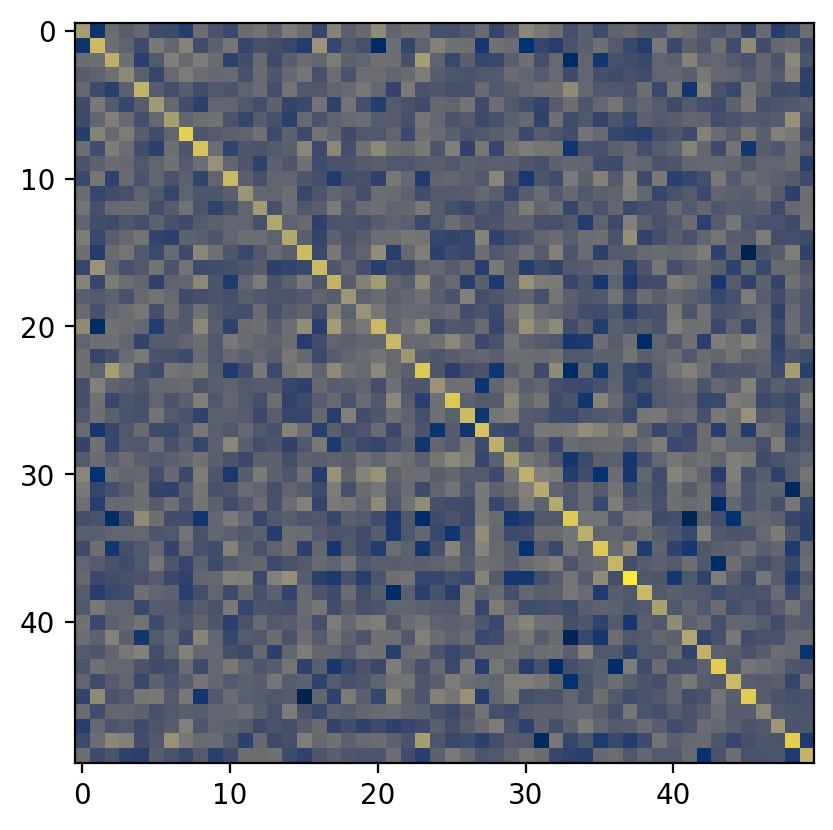

In [13]:
plt.imshow(jnp.cov(z_decoder.T), cmap="cividis")

## Analysing posterior observations

In [14]:
n_samples = 7
key_choice, keys_is = jax.random.split(key_samples)
keys_is = jax.random.split(keys_is, n_samples)

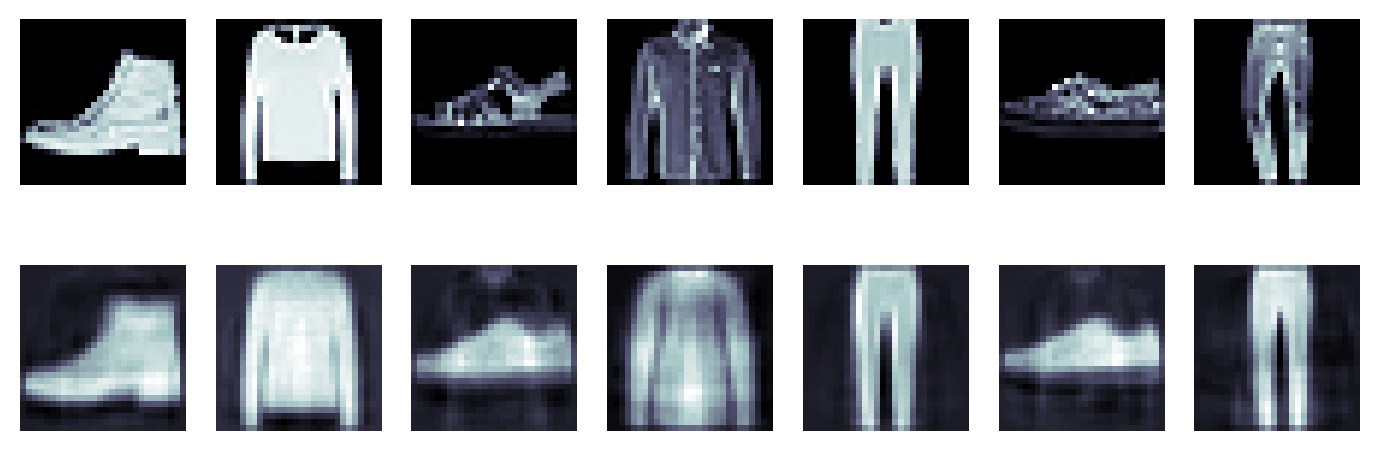

In [15]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, ax = plt.subplots(2, n_samples, figsize=(7, 3.0))

cmap = "bone"
for ax, ix, key in zip(ax.T, ixs_test, keys_is):
    obs = X_train[ix]
    mean_x, var_x = decoder.apply(params_decoder, z_decoder[ix])

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x.reshape(28, 28), cmap=cmap)
    ax[0].axis("off")
    ax[1].axis("off")
plt.tight_layout()